In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # 'tensorflow', 'jax´ or 'torch'
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import skforecast
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

2025-01-04 15:40:14.445347: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 15:40:14.774810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736001614.902230    9291 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736001614.934832    9291 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 15:40:15.167509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load the training data
train_energy = pd.read_csv('data/train_energy.csv')
# Parse DateTime column to datetime
train_energy['DateTime'] = pd.to_datetime(train_energy['DateTime'])

# Load the test data
test_energy = pd.read_csv('moh/to_adel.csv')
# Parse DateTime column to datetime
test_energy['DateTime'] = pd.to_datetime(test_energy['DateTime'])


In [3]:
# Merge train_energy with test_energy
data = pd.concat([train_energy, test_energy], ignore_index=True)


In [4]:

# Set DateTime column as index
data = data.set_index('DateTime')

# Set the frequency of the time series index
data.index.freq = 'h'

# Display the first few rows of the dataset
data


,EnergyConsumption(kWh)
DateTime,
2015-11-01 00:00:00,15.00000
2015-11-01 01:00:00,13.00000
2015-11-01 02:00:00,10.00000
2015-11-01 03:00:00,7.00000
2015-11-01 04:00:00,9.00000
...,...
2017-06-30 19:00:00,96.28962
2017-06-30 20:00:00,90.64792
2017-06-30 21:00:00,88.17324


In [5]:

# Checking the frequency of the time series
print(f"Index: {data.index.dtype}")
print(f"Frequency: {data.index.freq}")


Index: datetime64[ns]
Frequency: <Hour>


In [6]:
# Split train-validation-test
split_index_train = int(0.8 * len(train_energy))
split_index_val = len(train_energy)

train_energy_train = data[:split_index_train]
train_energy_val = data[split_index_train:split_index_val]
train_energy_test = data[split_index_val:]


In [7]:

print(
    f"Dates train      : {train_energy_train.index.min()} --- "
    f"{train_energy_train.index.max()}  (n={len(train_energy_train)})"
)
print(
    f"Dates validation : {train_energy_val.index.min()} --- "
    f"{train_energy_val.index.max()}  (n={len(train_energy_val)})"
)
print(
    f"Dates test       : {train_energy_test.index.min()} --- "
    f"{train_energy_test.index.max()}  (n={len(train_energy_test)})"
)

Dates train      : 2015-11-01 00:00:00 --- 2016-10-07 14:00:00  (n=8199)
Dates validation : 2016-10-07 15:00:00 --- 2017-01-01 00:00:00  (n=2050)
Dates test       : 2017-01-01 01:00:00 --- 2017-06-30 23:00:00  (n=4343)


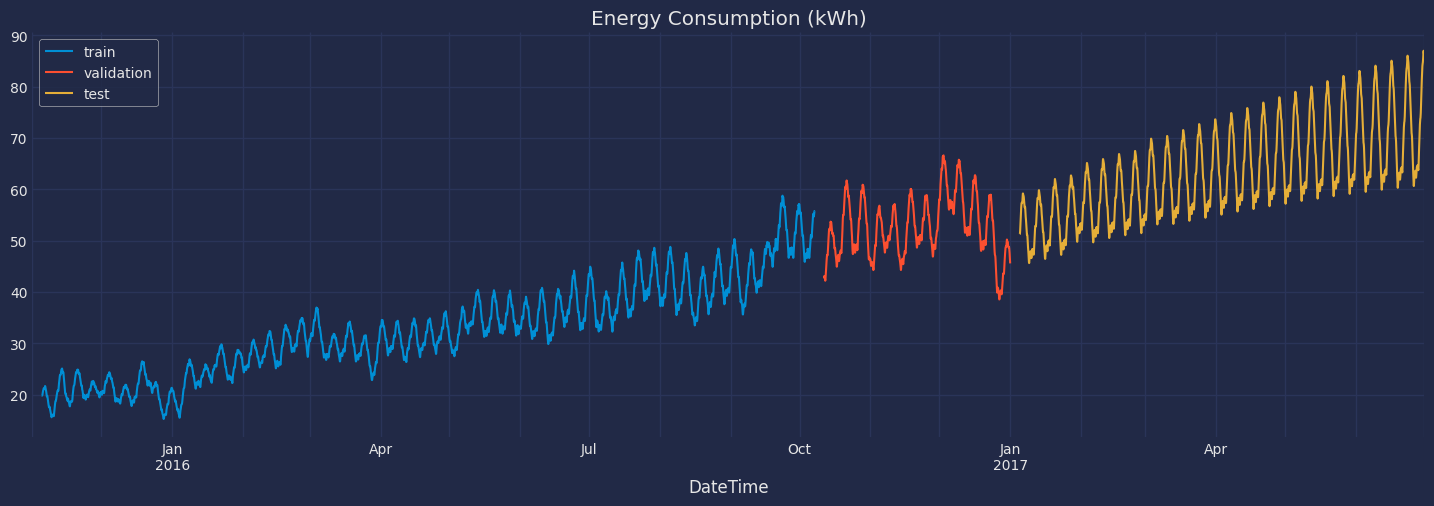

In [8]:
# Plotting one feature
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(16, 5))
train_energy_train["EnergyConsumption(kWh)"].rolling(100).mean().plot(ax=ax, label="train")
train_energy_val["EnergyConsumption(kWh)"].rolling(100).mean().plot(ax=ax, label="validation")
train_energy_test["EnergyConsumption(kWh)"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("Energy Consumption (kWh)")
ax.legend();

In [9]:
# Model creation
# ==============================================================================
series = ["EnergyConsumption(kWh)"]  # Series used as predictors
levels = ["EnergyConsumption(kWh)"]  # Target series to predict
lags = 32  # Past time steps to be used to predict the target
steps = 5  # Future time steps to be predicted

model = create_and_compile_model(
    series=train_energy_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=200,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,197 (657.02 KB)

 Trainable params: 168,197 (657.02 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 30,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10)
        ],  # Callback to stop training when it is no longer learning.
        # "series_val": train_energy_val,  # Validation data for model training.
    },
)    

forecaster

/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:229: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/home/adel_hb/.local/lib/python3.10/site-packages/skforecast/deep_learning/_forecaster_rnn.py:264: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <Functional name=functional, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['EnergyConsumption(kWh)'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_ba

In [11]:
# Fit forecaster
# ==============================================================================
forecaster.fit(train_energy_train)

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2889.6006
Epoch 2/30
 10/256 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0197

/home/adel_hb/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0178
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0151
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0138
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0115
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0110
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0096
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0074
Epoch 9/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0064
Epoch 10/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0063
Epoch 11/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0059
Epoch 12/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0054
Epoch 13/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0049
Epoch 14/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0046
Epoch 15/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0042
Epoch 16/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step

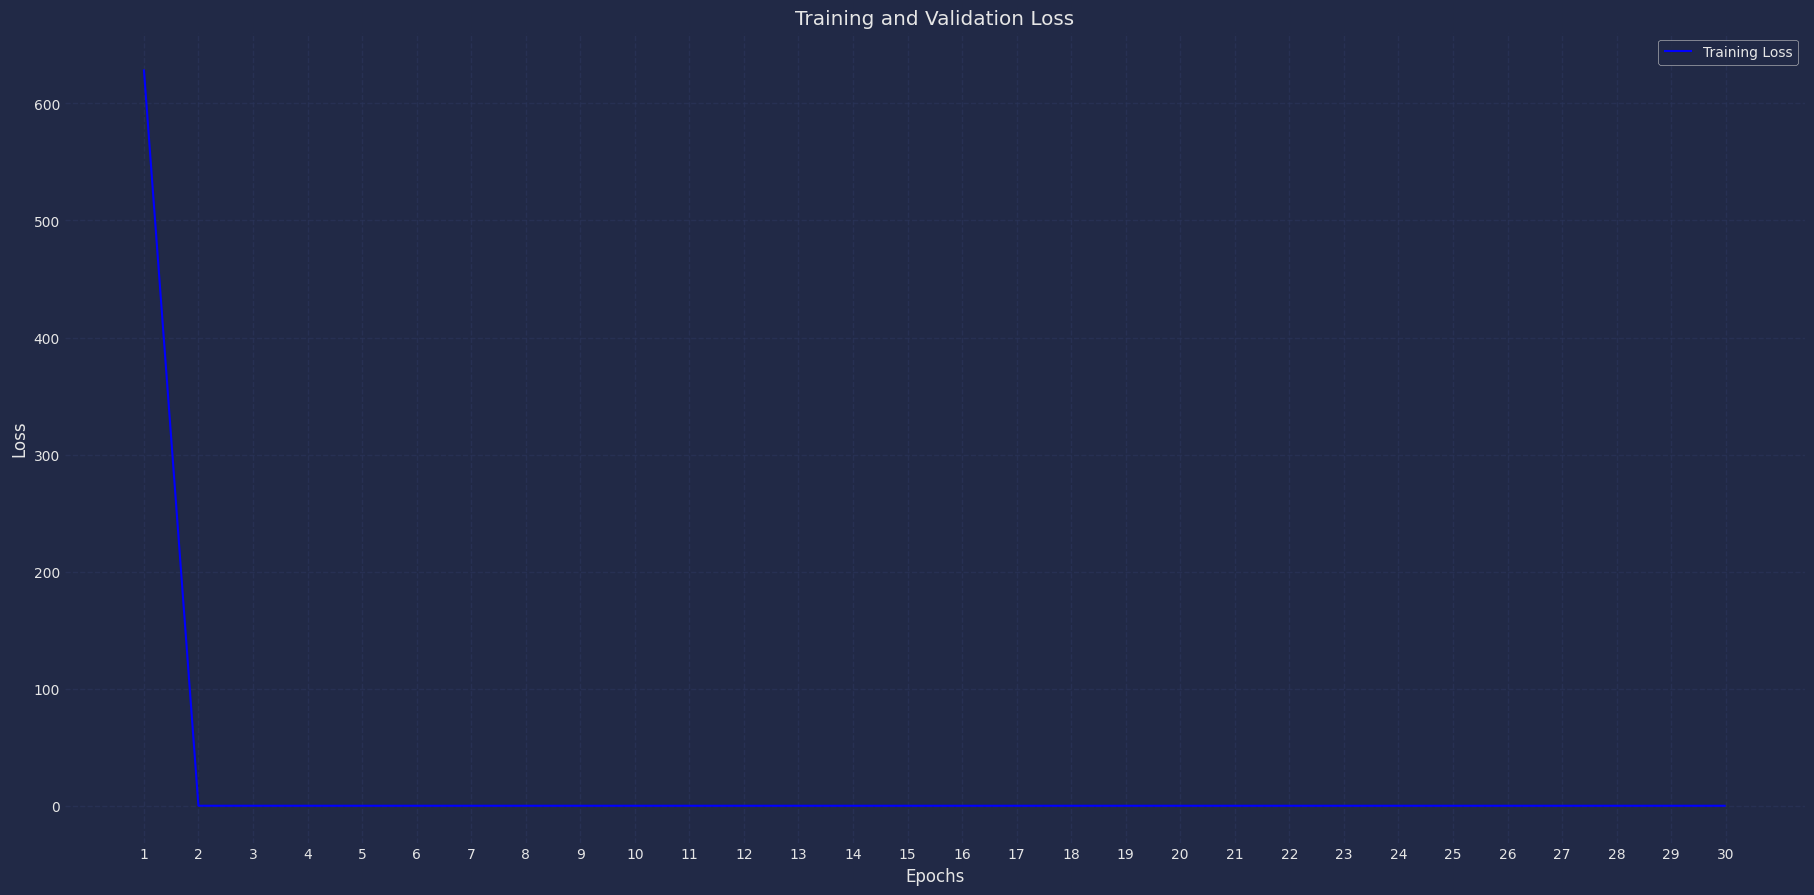

In [12]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 10))
forecaster.plot_history(ax=ax)

In [13]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,EnergyConsumption(kWh)
2016-10-07 15:00:00,49.070072
2016-10-07 16:00:00,51.047005
2016-10-07 17:00:00,53.524818
2016-10-07 18:00:00,53.250015
2016-10-07 19:00:00,56.330944


In [14]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,EnergyConsumption(kWh)
2016-10-07 15:00:00,49.070072
2016-10-07 17:00:00,53.524818


In [15]:
# Backtesting 
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = split_index_val,  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    cv=cv,
    levels=forecaster.levels,
    metric="mean_absolute_error",
    verbose=False
)

Epoch 1/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0021
Epoch 2/30
  7/320 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0023

/home/adel_hb/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0021
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0021
Epoch 4/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0021
Epoch 5/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0020
Epoch 6/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0022
Epoch 7/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0022
Epoch 8/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0020
Epoch 9/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0020
Epoch 10/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0020
Epoch 11/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0020
Epoch 12/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0020
Epoch 13/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0020
Epoch 14/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0020
Epoch 15/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0020
Epoch 16/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/s

  0%|          | 0/869 [00:00<?, ?it/s]

In [16]:
# Backtesting predictions
# ==============================================================================
predictions

,EnergyConsumption(kWh)
2017-01-01 01:00:00,27.389050
2017-01-01 02:00:00,25.461288
2017-01-01 03:00:00,21.175432
2017-01-01 04:00:00,19.631124
2017-01-01 05:00:00,17.374329
...,...
2017-06-30 19:00:00,102.200890
2017-06-30 20:00:00,99.606918
2017-06-30 21:00:00,97.306747
2017-06-30 22:00:00,96.630928


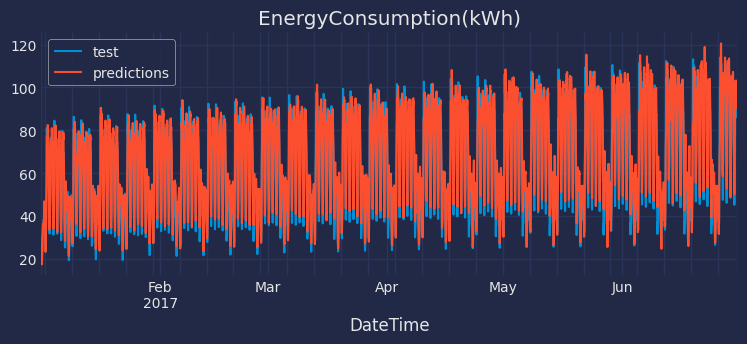

In [17]:
# Plotting predictions vs real values in the test set
# ==============================================================================
# Ensure predictions have the same index as the test set
predictions.index = train_energy_test.index

fig, ax = plt.subplots(figsize=(8, 3))
train_energy_test["EnergyConsumption(kWh)"].plot(ax=ax, label="test")
predictions["EnergyConsumption(kWh)"].plot(ax=ax, label="predictions")
ax.set_title("EnergyConsumption(kWh)")
ax.legend();

In [18]:
# Calculate metrics (MAE, MSE, RMSE, MAPE)
# ==============================================================================
from sklearn.metrics import mean_squared_error

# Calculate mean squared error
mse = mean_squared_error(train_energy_test["EnergyConsumption(kWh)"], predictions["EnergyConsumption(kWh)"])
metrics["mean_squared_error"] = mse

# Calculate root mean squared error
rmse = np.sqrt(metrics["mean_squared_error"])

metrics, rmse

(                   levels  mean_absolute_error  mean_squared_error
 0  EnergyConsumption(kWh)             5.692493           53.249687,
 0    7.297238
 Name: mean_squared_error, dtype: float64)

In [19]:
# Save predictions to CSV
# ==============================================================================
# Ensure predictions have the same index as the test set
predictions.index = train_energy_test.index

# Save predictions to CSV
predictions.to_csv('skforecast_submission.csv', index=True)

# Display the first few rows of the saved predictions
print(predictions.head())

                     EnergyConsumption(kWh)
DateTime                                   
2017-01-01 01:00:00               27.389050
2017-01-01 02:00:00               25.461288
2017-01-01 03:00:00               21.175432
2017-01-01 04:00:00               19.631124
2017-01-01 05:00:00               17.374329
